In [ ]:
#ts added
!pip install tensorflow_model_optimization

In [ ]:
## Necessary imports ---------------------------------------------------------------- ##
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16, InceptionV3, Xception, EfficientNetB0, VGG19
import math
from tensorflow.keras.regularizers import l2

import os
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import img_to_array, load_img

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras import Input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import DenseNet121 ## Check https://keras.io/api/applications/ for other models, or load the TL model in another way
from tensorflow.keras.models import Model 
from tensorflow.keras.optimizers import Adam

import tensorflow_model_optimization as tfmot ## Assuming you have installed tensorflow_model_optimization

import logging
import tempfile
import os

## ---------------------------------------------------------------------------------- ##

In [ ]:
train_directory = '/content/drive/MyDrive/MobileApps/Chinese Food Dataset/Train' ## Path to train dir
test_directory = '/content/drive/MyDrive/MobileApps/Chinese Food Dataset/Test' ## Path to test dir


## Image data generator + flow_from_directory
## You could also just load the images into the notebook manually, this is better for memory

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_directory,
    target_size=(224, 224),
    batch_size=32,
    class_mode='sparse'  # For use with sparse_categorical_crossentropy loss
)

validation_generator = test_datagen.flow_from_directory(
    test_directory,
    target_size=(224, 224),
    batch_size=32,
    class_mode='sparse'
)

## Define the number of classes
num_classes = 8

Found 4000 images belonging to 8 classes.
Found 366 images belonging to 8 classes.


In [ ]:
base_model = DenseNet121(weights='imagenet', include_top=False, input_tensor=Input(shape=(224, 224, 3))) ## We are using DenseNet121 for this demonstration - but any other TL model should work in the same way. 
## Shape gives us the pixel-wise size of the image. Make sure that the image size is compatible with the base_model that you are selecting.
## Loading in the base model, we are using DenseNet121 in this case. Weights are based on the imagenet dataset. 


## Set the layers to trainable (you can also set this to false to only train the classification layers at the end that we add on)
for layer in base_model.layers:
    layer.trainable = True


## The actual model itself
## Adding an average pooling layer on top of the base_model, then a dense layer for classification + a dropout. This can be modified as per the requirements / computational availability. 
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(num_classes, activation='softmax')(x) ## Final layer, to classify / predict into one of the 8 classes.


model = Model(inputs=base_model.input, outputs=predictions)


model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy']) ## Using sparse_categorical_crossentropy as the loss function (classification problem)

## Here, we are using metrics = ['accuracy'] because the dataset is balanced. 
## If you want to use F1-Score, then add the following lines of code: 

# from tensorflow.keras import backend as K

# def F1_Score(y_true, y_pred): #taken from old keras source code
#     true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
#     possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
#     predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
#     precision = true_positives / (predicted_positives + K.epsilon())
#     recall = true_positives / (possible_positives + K.epsilon())
#     f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
#     return f1_val

## Change the compile() to the following: 
##     model.compile(optimizer=tf.keras.optimizers.Adam(1e-4), loss='sparse_categorical_crossentropy', metrics=['accuracy', F1_Score])


model.summary()

## This is the base model. You can continue to train this and run model.fit(), but for now, we will not train the base model. 
## This notebook only gives us the annotated model's QAT.


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 zero_padding2d (ZeroPaddin  (None, 230, 230, 3)          0         ['input_1[0][0]']             
 g2D)                                                                                             
                                                                                                  
 conv1/conv (Conv2D)         (None, 112, 112, 64)         9408      ['zero_padding2d[0][0]']      
                                                                                                  
 conv1/bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1/conv[0][0]']      

In [ ]:
## This is required to clone the model for QAT. 

def apply_quantization(layer):
        if isinstance(layer, tf.keras.layers.Conv2D) or isinstance(layer, tf.keras.layers.Dense):
            return tfmot.quantization.keras.quantize_annotate_layer(layer)
        return layer

In [ ]:
## Newer versions of Keras require the model to be annotated. The clone_function will apply the quantization (layer-wise)
annotated_model = tf.keras.models.clone_model(
    model,
    clone_function=apply_quantization,
)

In [ ]:
## Recompile the model. Parameters are the same, just represented differently. 


annotated_model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)


annotated_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 zero_padding2d (ZeroPaddin  (None, 230, 230, 3)          0         ['input_1[0][0]']             
 g2D)                                                                                             
                                                                                                  
 quantize_annotate (Quantiz  (None, 112, 112, 64)         9408      ['zero_padding2d[1][0]']      
 eAnnotate)                                                                                       
                                                                                              

In [ ]:
## Training the model: 
annotated_model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=20,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size
)

Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/backend.py:5727: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


125/125 [==============================] - 117s 469ms/step - loss: 0.7859 - accuracy: 0.7590 - val_loss: 3.4251 - val_accuracy: 0.6080
Epoch 2/20
125/125 [==============================] - 57s 458ms/step - loss: 0.5155 - accuracy: 0.8428 - val_loss: 0.6694 - val_accuracy: 0.8153
Epoch 3/20
125/125 [==============================] - 58s 460ms/step - loss: 0.4346 - accuracy: 0.8730 - val_loss: 0.9151 - val_accuracy: 0.8040
Epoch 4/20
125/125 [==============================] - 58s 465ms/step - loss: 0.3566 - accuracy: 0.8820 - val_loss: 0.5298 - val_accuracy: 0.8580
Epoch 5/20
125/125 [==============================] - 58s 466ms/step - loss: 0.3836 - accuracy: 0.8857 - val_loss: 0.5193 - val_accuracy: 0.8636
Epoch 6/20
125/125 [==============================] - 58s 466ms/step - loss: 0.3046 - accuracy: 0.9070 - val_loss: 0.4930 - val_accuracy: 0.8551
Epoch 7/20
125/125 [==============================] - 58s 461ms/step - loss: 0.3033 - accuracy: 0.9103 - val_loss: 0.3039 - val_accuracy: 0.

In [ ]:
# Evaluate the model on the testing data
loss, accuracy = annotated_model.evaluate(validation_generator)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)

12/12 [==============================] - 3s 268ms/step - loss: 0.3140 - accuracy: 0.9126
Test Loss: 0.3140483498573303
Test Accuracy: 0.9125683307647705


In [ ]:
## Now that we have run the QAT, conversion of the annotated model into a .tflite model will quantize. 
## The following will return a .tflite converted model.

converter = tf.lite.TFLiteConverter.from_keras_model(annotated_model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]

quantized_tflite_model = converter.convert()

In [ ]:
## Save the .tflite model:

tflite_model_path = "/content/drive/MyDrive/MobileApps/QAT_DenseNet121.tflite"
with open(tflite_model_path, 'wb') as f:
    f.write(quantized_tflite_model)

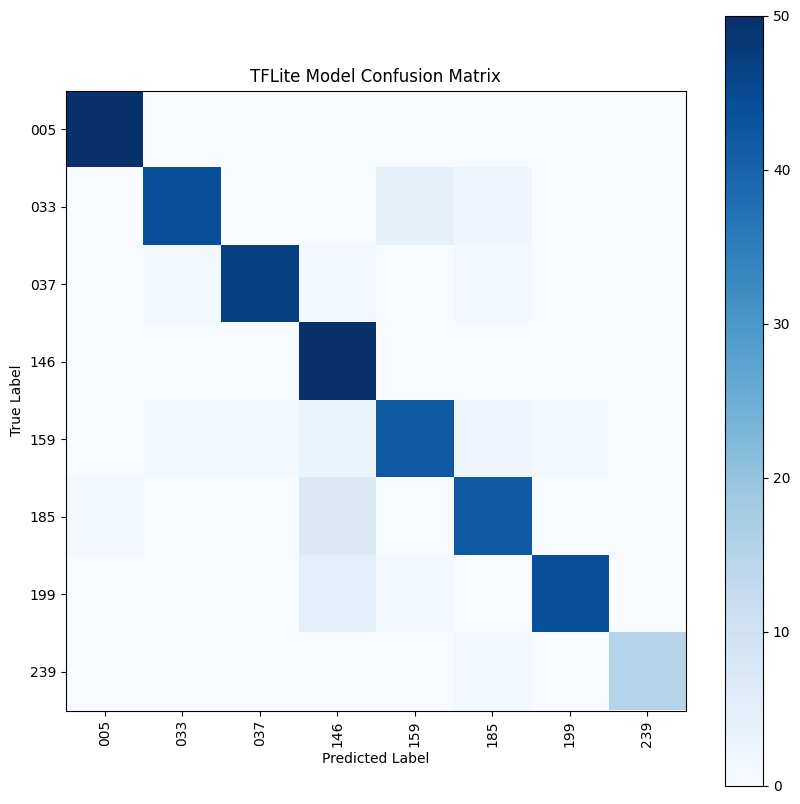

In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

# Load the TFLite model and allocate tensors
interpreter = tf.lite.Interpreter(model_path=tflite_model_path)
interpreter.allocate_tensors()

input_index = interpreter.get_input_details()[0]['index']
output_index = interpreter.get_output_details()[0]['index']

# Function to run predictions with the TFLite model
def run_tflite_model(images):
    predictions = []
    for i in range(images.shape[0]):
        interpreter.set_tensor(input_index, images[i][np.newaxis, :, :, :])
        interpreter.invoke()
        output_data = interpreter.get_tensor(output_index)
        predictions.append(output_data[0])
    return np.array(predictions)

# Evaluate the TFLite model
predicted_classes = []
true_classes = []
for images, labels in validation_generator:
    tflite_predictions = run_tflite_model(images)
    predicted_classes.extend(np.argmax(tflite_predictions, axis=1))
    true_classes.extend(labels)
    if len(predicted_classes) >= validation_generator.samples:
        break

# Compute the confusion matrix
cm = confusion_matrix(true_classes, predicted_classes[:len(true_classes)])

# Plot the confusion matrix
plt.figure(figsize=(10, 10))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('TFLite Model Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(validation_generator.class_indices))
plt.xticks(tick_marks, validation_generator.class_indices.keys(), rotation=90)
plt.yticks(tick_marks, validation_generator.class_indices.keys())
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.grid(False)
plt.show()


In [ ]:
import numpy as np

def evaluate_tflite_model_accuracy(interpreter, validation_generator):
    input_index = interpreter.get_input_details()[0]['index']
    output_index = interpreter.get_output_details()[0]['index']

    total_seen = 0
    total_correct = 0

    # Iterate over the validation generator
    for images, labels in validation_generator:
        for i in range(images.shape[0]):
            # Prepare input data and run the model
            interpreter.set_tensor(input_index, images[i][np.newaxis, :, :, :])
            interpreter.invoke()
            output_data = interpreter.get_tensor(output_index)
            predicted_label = np.argmax(output_data[0])
            true_label = labels[i]

            # Compare predicted and true labels
            if predicted_label == true_label:
                total_correct += 1
            total_seen += 1

        # Stop when enough samples have been processed
        if total_seen >= validation_generator.samples:
            break

    # Calculate accuracy
    accuracy = total_correct / total_seen
    return accuracy

# Load the TFLite model and allocate tensors
interpreter = tf.lite.Interpreter(model_path="/content/drive/MyDrive/MobileApps/QAT_DenseNet121.tflite")
interpreter.allocate_tensors()

# Evaluate the TFLite model's accuracy
accuracy = evaluate_tflite_model_accuracy(interpreter, validation_generator)
print("TFLite Model Testing Accuracy: {:.2f}%".format(accuracy * 100))


TFLite Model Testing Accuracy: 91.26%
